## News Similarity Analysis

In [133]:
# read the preprocess data: 
import pandas as pd 
import numpy as np
import scanpy as sc 
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import randomly

import numpy as np
from utilities import *
import pandas as pd
import seaborn as sns
import scanpy as sc 

def convert_string_to_float(s):
    s_without_commas = s.replace(',', '')
    return float(s_without_commas)

sns.set_style('whitegrid')

adata = sc.read_h5ad('Data/adata_test.h5ad')

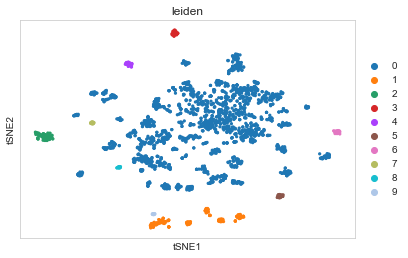

In [146]:
# default setting 
sc.tl.pca(adata, svd_solver = "arpack")
sc.pp.neighbors(adata, n_neighbors = 30)
sc.tl.tsne(adata)
sc.tl.leiden(adata, resolution = 0.01)
sc.pl.tsne(adata, color = "leiden")

In [135]:
price = pd.read_excel("Data/lithium_price.xlsx")
price.Date = price.Date.apply(transform_date_price)
price[["Open", "High", "Low","Close"]] = price[["Open", "High", "Low","Close"]].applymap(convert_string_to_float)
price.columns = ['date', 'open', 'high','low','close','change','volume']

price_close = pd.DataFrame(price.close)
price_close['date'] = price.date

price_close = price_close.sort_values("date")
price_close['date'] = pd.to_datetime(price_close['date'])
# Set the date column as the index
price_close = price_close.set_index('date')

In [136]:
# Create a new date range
date_range = pd.date_range(start='2017-05-10', end='2023-05-22')

# Reindex the dataframe using the new date range, forward fill missing values
price_close = price_close.reindex(date_range, method='ffill')
price_close.sort_index(inplace = True, ascending = False)
price_close.head()

,close
2023-05-22,227500.0
2023-05-21,227500.0
2023-05-20,227500.0
2023-05-19,227500.0
2023-05-18,227500.0


In [137]:
outlier_cutoff = 0.01
data_eng = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data_eng [f'return_{lag}d'] = -(price_close
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data_eng  = data_eng.swaplevel().dropna()

In [138]:
data_eng

return_1d  return_2d  return_3d  return_6d  return_9d  \
close 2023-05-10  -0.000000   0.012423   0.008299   0.018995   0.015590   
      2023-05-09   0.025316   0.012739   0.016740   0.012428   0.016477   
      2023-05-08  -0.000000   0.012739   0.008511   0.008405   0.016477   
      2023-05-07   0.028498   0.026671   0.024784   0.018995   0.016477   
      2023-05-06  -0.000000   0.026671   0.024784   0.018995   0.016477   
...                     ...        ...        ...        ...        ...   
      2017-05-14  -0.000000  -0.000000  -0.000000   0.005999   0.004004   
      2017-05-13  -0.000000  -0.000000  -0.000000   0.005999   0.004004   
      2017-05-12  -0.000000  -0.000000  -0.000000  -0.000000   0.004004   
      2017-05-11  -0.000000  -0.000000  -0.000000  -0.000000   0.004004   
      2017-05-10  -0.000000  -0.000000  -0.000000  -0.000000   0.004004   

                  return_12d  
close 2023-05-10    0.011715  
      2023-05-09    0.013825  
      2023-05-08    0.013825  
      2023-05-07    0.015466  
      2023-05-06    0.015466  
...                      ...  
      2017-05-14    0.003004  
      2017-05-13    0.003004  
      2017-05-12    0.003004  
      2017-05-11    0.003004  
      2017-05-10    0.003004  

[2192 rows x 6 columns]

In [139]:
df_return = data_eng.reset_index().drop('level_0', axis = 1)
df_return.columns = ['date', 'return_1d', 'return_2d', 'return_3d', 'return_6d', \
       'return_9d', 'return_12d']
df_return['date'] = df_return['date'].astype(str)
df_return.head(10)

,date,return_1d,return_2d,return_3d,return_6d,return_9d,return_12d
0,2023-05-10,-0.000000,0.012423,0.008299,0.018995,0.015590,0.011715
1,2023-05-09,0.025316,0.012739,0.016740,0.012428,0.016477,0.013825
2,2023-05-08,-0.000000,0.012739,0.008511,0.008405,0.016477,0.013825
3,2023-05-07,0.028498,0.026671,0.024784,0.018995,0.016477,0.015466
4,2023-05-06,-0.000000,0.026671,0.024784,0.018995,0.016477,0.015466
5,2023-05-05,-0.000000,-0.000000,0.024784,0.017637,0.014534,0.015466
6,2023-05-04,-0.000000,-0.000000,-0.000000,0.017637,0.014534,0.015466
7,2023-05-03,-0.000000,-0.000000,-0.000000,0.013430,0.014534,0.012929
8,2023-05-02,-0.000000,-0.000000,-0.000000,0.013430,0.011793,0.010921
9,2023-05-01,0.028169,0.014185,0.009479,0.004751,0.014925,0.013273


In [140]:
# Convert 'date' column in adata.obs to datetime
df_obs = adata.obs
# Convert 'date' column in both dataframes to categorical
df_obs['date'] = df_obs['date'].astype(str)
df_obs.date

0       2023-05-01
1       2023-05-01
2       2023-05-01
3       2023-05-01
4       2023-05-01
           ...    
2821    2020-05-07
2822    2020-05-07
2823    2020-05-07
2824    2020-05-07
2825    2020-05-05
Name: date, Length: 2826, dtype: object

In [141]:
# Now you can proceed with the merge
df_obs = df_obs.merge(df_return, how="left", on="date")

In [142]:
adata.obs = df_obs

In [143]:
adata.obs

,date,url,text,leiden,return_1d,return_2d,return_3d,return_6d,return_9d,return_12d
0,2023-05-01,https://finance.yahoo.com/news/lithiumbank-app...,globenewswirelithiumbank appoints strategy exe...,0,0.028169,0.014185,0.009479,0.004751,0.014925,0.013273
1,2023-05-01,https://markets.financialcontent.com/stocks/ar...,recent quote view full list watchlist create w...,0,0.028169,0.014185,0.009479,0.004751,0.014925,0.013273
2,2023-05-01,https://www.naturalnews.com/2023-05-01-sodium-...,home brighteon prep mike interview audio book ...,0,0.028169,0.014185,0.009479,0.004751,0.014925,0.013273
3,2023-05-01,https://www.wkrb13.com/2023/05/01/piedmont-lit...,ad legacy research recent viewswarning mandato...,0,0.028169,0.014185,0.009479,0.004751,0.014925,0.013273
4,2023-05-01,https://thedeepdive.ca/chiles-lithium-industry...,full analysis late resource video series chile...,0,0.028169,0.014185,0.009479,0.004751,0.014925,0.013273
...,...,...,...,...,...,...,...,...,...,...
2821,2020-05-07,https://www.kitco.com/news/2020-05-07/UPDATE-1...,add detail greenbushes sale stock movement ern...,0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.002419
2822,2020-05-07,https://www.reuters.com/article/us-albemarle-t...,ernest scheyder min readreuters albemarle corp...,0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.002419
2823,2020-05-07,https://leaderpost.com/pmn/business-pmn/albema...,advertisement advertisement load yet article c...,0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.002419
2824,2020-05-07,https://www.reuters.com/article/albemarle-tian...,reuters staff min readmay reuters albemarle co...,0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.002419


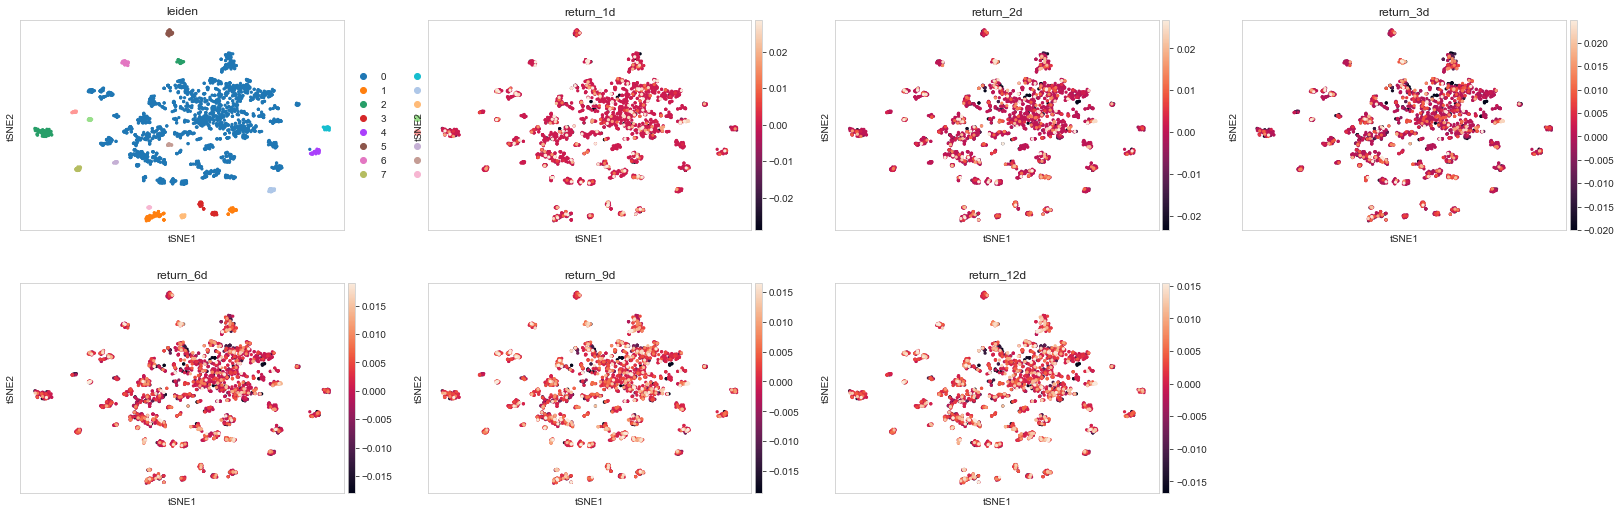

In [144]:
sc.pl.tsne(adata, color = ['leiden','return_1d', 'return_2d', 'return_3d', 'return_6d', 'return_9d',
       'return_12d'] )

In [112]:
df_return.columns

Index(['date', 'return_1d', 'return_2d', 'return_3d', 'return_6d', 'return_9d',
       'return_12d'],
      dtype='object')

In [145]:
len(adata.var_names)

7179